In [1]:
from google.colab import files

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manojk1323","key":"3c38415542b555dc4234b52347aae6f1"}'}

In [3]:
import os

# Create the .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move kaggle.json into the directory
!mv kaggle.json /root/.kaggle/

# Change permissions
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d manojk1323/sign-language-pre-processed-for-27-words

Dataset URL: https://www.kaggle.com/datasets/manojk1323/sign-language-pre-processed-for-27-words
License(s): unknown
 99% 457M/462M [00:05<00:00, 129MB/s]
100% 462M/462M [00:05<00:00, 85.3MB/s]


In [5]:
# prompt: unzip the dataset file
!unzip sign-language-pre-processed-for-27-words.zip

Archive:  sign-language-pre-processed-for-27-words.zip
  inflating: sign_27.csv             


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
# Load preprocessed DataFrame
df = pd.read_csv(r'/content/sign_27.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32865 entries, 0 to 32864
Columns: 1665 entries, action to kp_1661
dtypes: float64(1662), int64(1), object(2)
memory usage: 417.5+ MB


In [9]:
df.head(2)

,action,video,frame,kp_0,kp_1,kp_2,kp_3,kp_4,kp_5,kp_6,...,kp_1652,kp_1653,kp_1654,kp_1655,kp_1656,kp_1657,kp_1658,kp_1659,kp_1660,kp_1661
0,good night,MVI_005_6.MOV,0,0.489297,0.146612,-0.502261,0.999895,0.499013,0.123582,-0.481440,...,-0.001275,0.409427,0.832730,-0.003213,0.417676,0.843267,-0.002958,0.424856,0.848169,-0.002093
1,good night,MVI_005_6.MOV,1,0.488763,0.148646,-0.501405,0.999897,0.498282,0.124194,-0.481308,...,-0.001907,0.409393,0.834686,-0.004285,0.417800,0.844495,-0.004322,0.424833,0.848541,-0.003665


## baisc pre-processing:-

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_frame_distribution(frame_counts):
    """
    Plots histogram, boxplot, and CDF to analyze the distribution of frames per video.

    Args:
        frame_counts (pd.Series): Series containing the frame count for each video.
    """
    plt.figure(figsize=(15, 5))

    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(frame_counts, bins=30, kde=True, color="blue")
    plt.axvline(frame_counts.median(), color='red', linestyle='dashed', label=f"Median: {frame_counts.median()}")
    plt.axvline(frame_counts.mean(), color='green', linestyle='dashed', label=f"Mean: {frame_counts.mean():.2f}")
    plt.legend()
    plt.xlabel("Number of Frames per Video")
    plt.ylabel("Frequency")
    plt.title("Histogram of Frame Counts")

    # Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(x=frame_counts, color="orange")
    plt.xlabel("Number of Frames per Video")
    plt.title("Boxplot of Frame Counts")

    # CDF Plot
    plt.subplot(1, 3, 3)
    sns.ecdfplot(frame_counts, color="purple")
    plt.axhline(0.9, color='red', linestyle='dashed', label="90% Coverage")
    plt.legend()
    plt.xlabel("Number of Frames per Video")
    plt.ylabel("Cumulative Probability")
    plt.title("CDF of Frame Counts")

    plt.tight_layout()
    plt.show()

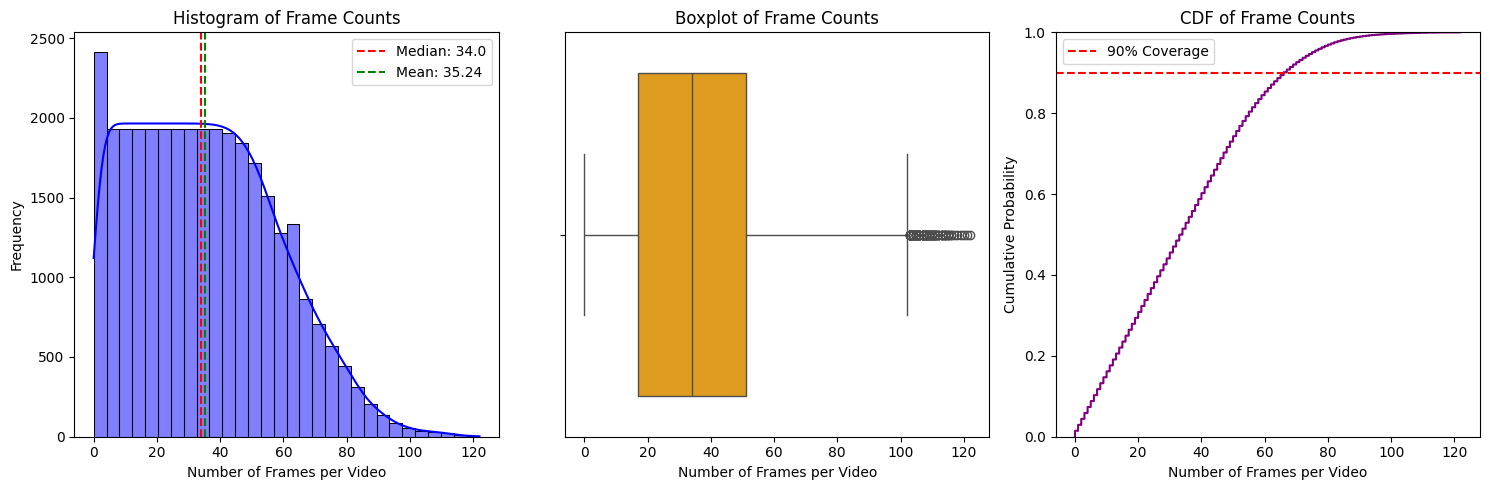

In [11]:
plot_frame_distribution(df["frame"])

In [12]:
df['frame'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122])

In [13]:
frame_count = df.groupby('video')['frame'].count()
print(frame_count)
print(f'max value:- ', frame_count.max())
print(f'min value:- ', frame_count.min())
print(frame_count.unique())

video
MVI_0001.MOV    55
MVI_0002.MOV    56
MVI_0003.MOV    60
MVI_0004.MOV    60
MVI_0006.MOV    53
                ..
MVI_9994.MOV    55
MVI_9995.MOV    63
MVI_9996.MOV    60
MVI_9998.MOV    54
MVI_9999.MOV    56
Name: frame, Length: 454, dtype: int64
max value:-  153
min value:-  36
[ 55  56  60  53  57  54  63  74  65  61  81  92  96  95 122 140 131  71
 151 139 143 153 146 128  87  90  64 141  62  91 149  84  89  82 137 130
 142  79  76  68  69  80  83 100  66  73  75  72  77 117  67  94 112  85
  99  97 103  88  86  98 104  78 109 123  93  70  59 116  44  40  48  51
 111 115 105 101  50  52  45  58  49  46  47  42  41  36  43 135 120 108
 134 138 124 125]


In [14]:
def trim_and_pad_frames(df, target_frames):
    new_data = []
    c = 0

    for video_name, video_df in df.groupby("video"):
        num_frames = len(video_df)

        # If frames exceed target, trim the last extra frames
        if num_frames > target_frames:
            video_df = video_df.iloc[:target_frames]  # Keep only the first `target_frames` frames

        # If frames are less than target, pad with zero rows
        elif num_frames < target_frames:
            keypoint_columns = video_df.drop(columns=["action", "video", "frame"]).columns
            padding_needed = target_frames - num_frames

            # Create zero-padded rows
            zero_padding = pd.DataFrame(np.full((padding_needed, len(keypoint_columns)), -99999), columns=keypoint_columns)
            zero_padding.insert(0, "video", video_name)
            zero_padding.insert(1, "frame", np.arange(num_frames + 1, target_frames + 1))  # New frame numbers
            zero_padding["action"] = video_df["action"].iloc[0]  # Maintain same action label

            video_df = pd.concat([video_df, zero_padding], ignore_index=True)

        # Ensure exactly `target_frames` per video
        assert len(video_df) == target_frames, f"Video {video_name} has {len(video_df)} frames, expected {target_frames}"

        new_data.append(video_df)

    print(f"Skipped count: -", c)
    return pd.concat(new_data, ignore_index=True)

In [15]:
df_trimmed = trim_and_pad_frames(df, target_frames=120)
df_trimmed.info()

Skipped count: - 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54480 entries, 0 to 54479
Columns: 1665 entries, action to kp_1661
dtypes: float64(1662), int64(1), object(2)
memory usage: 692.1+ MB


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32865 entries, 0 to 32864
Columns: 1665 entries, action to kp_1661
dtypes: float64(1662), int64(1), object(2)
memory usage: 417.5+ MB


In [17]:
df_trimmed.groupby("video")["frame"].count().unique()

array([120])

## Build and Train LSTM Neural Network:-

In [18]:
sequences, labels = [], []

# Ensure label_map is correctly defined
unique_actions = df_trimmed['action'].unique()
label_map = {action: i for i, action in enumerate(unique_actions)}

# Grouping videos
grouped = df_trimmed.groupby("video")

for video, group in grouped:
    group = group.sort_values('frame')  # Sort frames correctly
    keypoints_seq = group.iloc[:, 3:].values  # Extract only keypoints

    # Extract action from the group
    action = group['action'].iloc[0]  # Take first row (since all rows have the same action)

    sequences.append(keypoints_seq)
    labels.append(label_map[action])  # Convert action to label

In [19]:
reverse_label_map = {i: action for action, i in label_map.items()}
reverse_label_map

{0: 'good evening',
 1: 'good night',
 2: 'thank you',
 3: 'pleased',
 4: 'hello',
 5: 'how are you',
 6: 'alright',
 7: 'good morning',
 8: 'good afternoon',
 9: 'dog',
 10: 'cat',
 11: 'fish',
 12: 'bird',
 13: 'cow',
 14: 'extra',
 15: 'hat',
 16: 'dress',
 17: 'suit',
 18: 'skirt',
 19: 'shirt',
 20: 'loud',
 21: 'quiet',
 22: 'happy',
 23: 'sad',
 24: 'beautiful',
 25: 'ugly',
 26: 'deaf',
 27: 'blind'}

In [20]:
label_map

{'good evening': 0,
 'good night': 1,
 'thank you': 2,
 'pleased': 3,
 'hello': 4,
 'how are you': 5,
 'alright': 6,
 'good morning': 7,
 'good afternoon': 8,
 'dog': 9,
 'cat': 10,
 'fish': 11,
 'bird': 12,
 'cow': 13,
 'extra': 14,
 'hat': 15,
 'dress': 16,
 'suit': 17,
 'skirt': 18,
 'shirt': 19,
 'loud': 20,
 'quiet': 21,
 'happy': 22,
 'sad': 23,
 'beautiful': 24,
 'ugly': 25,
 'deaf': 26,
 'blind': 27}

In [21]:
# Convert to numpy arrays
X = np.array(sequences)
labels = np.array(labels)

# Convert labels to one-hot encoding
y = to_categorical(labels).astype(int)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, Masking, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

### trying to find the best model architecture using keras-tuner

In [24]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [25]:
import kerastuner as kt

<ipython-input-25-5fd8096cdee5>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [26]:
def build_model(hp):
    model = Sequential()

    # First loop for LSTM layers
    counter = 0
    for i in range(hp.Int('num_layer', min_value=1, max_value=5)):
        if counter == 0:
            model.add(Input(shape=(60, X.shape[2])))
            model.add(Masking(mask_value=-99999))
            model.add(
                Bidirectional(
                    LSTM(
                        hp.Int('units_' + str(i), min_value=16, max_value=128),
                        activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh']),
                        return_sequences=True,
                    )
                )
            )
            if hp.Boolean('BatchNormalization'):
              model.add(BatchNormalization())
            model.add(Dropout(hp.Choice('dropout_' + str(i), values=[0.2, 0.3, 0.4, 0.5])))
        else:
            model.add(
                Bidirectional(
                    LSTM(
                        hp.Int('units_' + str(i), min_value=16, max_value=64),
                        activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh']),
                        return_sequences=True,
                    )
                )
            )
            if hp.Boolean('BatchNormalization'):
              model.add(BatchNormalization())
            model.add(Dropout(hp.Choice('dropout_' + str(i), values=[0.2, 0.3, 0.4, 0.5])))

        counter += 1

    # Final LSTM layer
    model.add(
        Bidirectional(
            LSTM(
                hp.Int('units_final', min_value=16, max_value=64),
                activation=hp.Choice('activation_final', values=['relu', 'tanh']),
                return_sequences=False,
            )
        )
    )

    # Reset counter for Dense layers
    counter = 0

    # Second loop for Dense layers
    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=5)):
        if counter == 0:
            model.add(
                Dense(
                    hp.Int('units_dense_' + str(i), min_value=8, max_value=256, step=8),
                    activation=hp.Choice('activation_dense_' + str(i), values=['relu', 'tanh']),
                    input_dim=8,
                )
            )
            if hp.Boolean('BatchNormalization'):
              model.add(BatchNormalization())
            model.add(Dropout(hp.Choice('dropout_dense_' + str(i), values=[0.2, 0.3, 0.4, 0.5])))
        else:
            model.add(
                Dense(
                    hp.Int('units_dense_' + str(i), min_value=32, max_value=512),
                    activation=hp.Choice('activation_dense_' + str(i), values=['relu', 'tanh']),
                )
            )
            if hp.Boolean('BatchNormalization'):
              model.add(BatchNormalization())
            model.add(Dropout(hp.Choice('dropout_dense_' + str(i), values=[0.2, 0.3, 0.4, 0.5])))

        counter += 1

    model.add(Dense(28, activation='softmax'))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

    return model

In [28]:
tuner = kt.BayesianOptimization(build_model, objective='val_categorical_accuracy', max_trials=50, directory='first_run', project_name='signSpeak_hp')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

Trial 39 Complete [00h 01m 03s]
val_categorical_accuracy: 0.010989011265337467

Best val_categorical_accuracy So Far: 0.09890110045671463
Total elapsed time: 00h 51m 14s

Search: Running Trial #40

Value             |Best Value So Far |Hyperparameter
5                 |1                 |num_layer
19                |79                |units_0
relu              |tanh              |activation_0
False             |False             |BatchNormalization
0.2               |0.3               |dropout_0
19                |33                |units_final
tanh              |tanh              |activation_final
5                 |2                 |num_dense_layers
248               |168               |units_dense_0
tanh              |relu              |activation_dense_0
0.5               |0.2               |dropout_dense_0
0.00042144        |0.00025045        |lr
19                |30                |units_1
relu              |tanh              |activation_1
0.3               |0.5               |

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'num_layer': 3,
 'units_0': 124,
 'activation_0': 'tanh',
 'BatchNormalization': False,
 'dropout_0': 0.6,
 'units_final': 97,
 'activation_final': 'relu',
 'num_dense_layers': 1,
 'units_dense_0': 192,
 'activation_dense_0': 'tanh',
 'dropout_dense_0': 0.5,
 'optimizer': 'adam',
 'units_1': 75,
 'activation_1': 'relu',
 'dropout_1': 0.6,
 'units_2': 80,
 'activation_2': 'tanh',
 'dropout_2': 0.9,
 'units_dense_1': 56,
 'activation_dense_1': 'sigmoid',
 'dropout_dense_1': 0.7,
 'units_dense_2': 120,
 'activation_dense_2': 'relu',
 'dropout_dense_2': 0.6,
 'units_dense_3': 224,
 'activation_dense_3': 'tanh',
 'dropout_dense_3': 0.9,
 'units_3': 122,
 'activation_3': 'relu',
 'dropout_3': 0.8,
 'units_4': 115,
 'activation_4': 'tanh',
 'dropout_4': 0.9,
 'units_5': 26,
 'activation_5': 'tanh',
 'dropout_5': 0.3,
 'units_6': 27,
 'activation_6': 'tanh',
 'dropout_6': 0.7,
 'units_7': 93,
 'activation_7': 'relu',
 'dropout_7': 0.7,
 'units_8': 46,
 'activation_8': 'relu',
 'dropout_8': 0.

In [ ]:
model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 60, 1662)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 60, 248)             │       1,772,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 248)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 60, 150)             │         194,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 60, 160)             │         147,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 160)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 194)                 │         200,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 192)                 │          37,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 28)                  │           5,404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,357,996 (9.00 MB)

 Trainable params: 2,357,996 (9.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks for better training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, verbose=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, initial_epoch=3, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - categorical_accuracy: 0.0294 - loss: 3.5075 - val_categorical_accuracy: 0.0330 - val_loss: 3.3354 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - categorical_accuracy: 0.0794 - loss: 3.4672 - val_categorical_accuracy: 0.0220 - val_loss: 3.3433 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - categorical_accuracy: 0.0340 - loss: 3.4234 - val_categorical_accuracy: 0.0330 - val_loss: 3.3559 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - categorical_accuracy: 0.0299 - loss: 3.4941 - val_categorical_accuracy: 0.0330 - val_loss: 3.3265 - learning_rate: 0.0010
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - categorical_accuracy: 0.0467 - loss: 3.4210 - val_categorical_accuracy: 0.0549 - val_loss: 3.3361 - learning_rate: 0.0010
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - categorical_accuracy: 0.0459 - loss: 3.3918 - val_categorical_accuracy: 

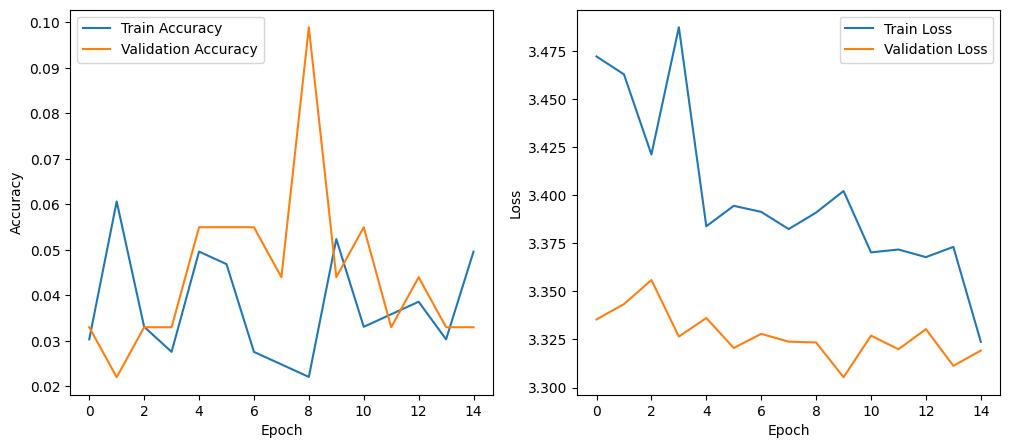

In [ ]:
# Plot Accuracy & Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## model predictions:-

In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[0])]

## Saving the model:-

In [ ]:
model.save('4->hp-tuned.keras')

In [ ]:
model

In [ ]:
del model

In [ ]:
model = load_model('/kaggle/working/sl_sign.keras')

## Evaluating using Confusion Matrix and Accuracy:-

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_train)

In [ ]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
accuracy_score(ytrue, yhat)

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)